In [24]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#Inspect Data
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 10000)
df = pd.read_csv('../data/dataset.csv')

(-1.100000003139035,
 1.1000000001494779,
 -1.1002690692842618,
 1.100269067788945)

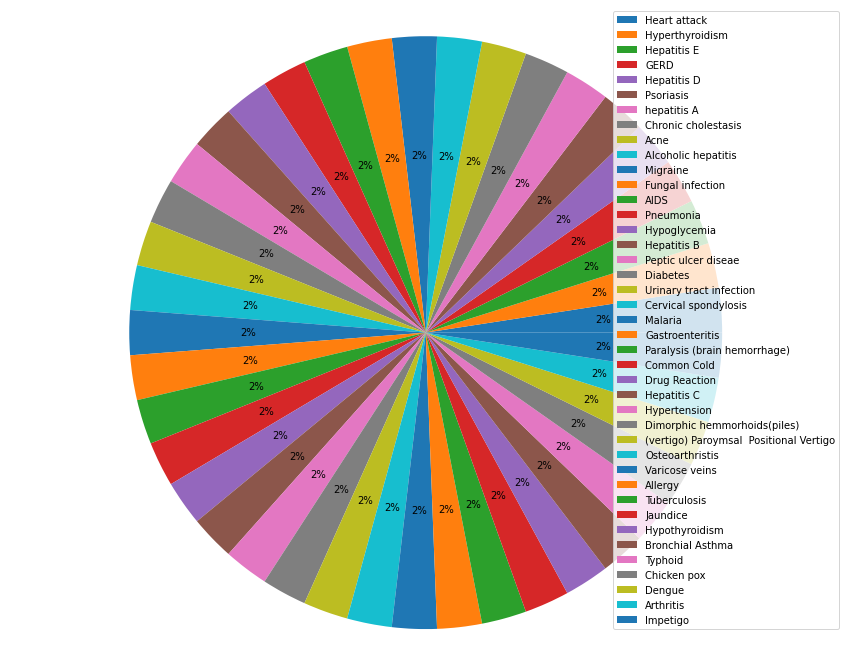

In [6]:
#Data spread
data_spread = df['Disease'].value_counts().reset_index()
plt.figure(figsize=(15, 12))
plt.pie(data_spread['Disease'], autopct='%d%%')
plt.legend(data_spread['index'])
plt.axis('equal')

In [7]:
#Model does not accept nan values, so we need to change them
df.fillna('No Symptom', inplace=True)
df = df.applymap(lambda row: row.strip())

In [8]:
#Create unique symptoms list in order to encode them
symptoms_list = []
for i in range(1, 18):
    symptoms = df.iloc[:, i].unique()
    for symptom in symptoms:
        symptoms_list.append(symptom)

In [9]:
#Encoding label
label_encoder = LabelEncoder().fit(np.array(symptoms_list))
for i in range(1, 18):
    df.iloc[:, i] = label_encoder.transform(df.iloc[:, i])

In [10]:
#Create feature set(x) and target(y)
x = df.iloc[:, 1:]
y = df['Disease']

#Train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [29]:
#Random Forest for classification
disease_forest = RandomForestClassifier().fit(x_train, y_train)
scores = cross_validate(disease_forest, x, y, cv=10, scoring=['precision_macro', 'recall_macro', 'f1_macro'])
print(scores)

{'fit_time': array([0.32549143, 0.34680247, 0.32050467, 0.31639981, 0.31331396,
       0.31470442, 0.31614137, 0.31562924, 0.31881499, 0.31507635]), 'score_time': array([0.03381252, 0.03367829, 0.03339028, 0.03307867, 0.03339219,
       0.03169513, 0.03152823, 0.03156233, 0.0316608 , 0.03158665]), 'test_precision_macro': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'test_recall_macro': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'test_f1_macro': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}


In [30]:
#User input prediction
user_input = ['cough', 'headache', 'sweating']
while len(user_input) < 17:
    user_input.append('No Symptom')

#Encode user input and predict top 5 possible diagnoses
user_input = label_encoder.transform(np.array(user_input)).reshape(-1, 17)
diagnose = disease_forest.predict_proba(user_input)
index_of_maximum_proba = diagnose.argsort()[0][-5:][::-1]
predicted_classes = disease_forest.classes_[index_of_maximum_proba]

#Get description df
descriptions_df = pd.read_csv('../data/symptom_Description.csv')

#Get precautions df
precautions_df = pd.read_csv('../data/symptom_precaution.csv')

#Precaution and
precaution_description_df = pd.merge(descriptions_df, precautions_df, how='outer').set_index('Disease').loc[predicted_classes]
precaution_description_df['Probability'] = pd.Series(data = diagnose[0][index_of_maximum_proba], index = predicted_classes).apply(lambda probability: str(round(probability*100, 1)) + '%')

precaution_description_dict = precaution_description_df.T.to_dict()
for disease, descriptions_precaution_probability in precaution_description_dict.items():
    print(f'The disease: {disease}\n')
    for k, v in descriptions_precaution_probability.items():
        print(f'\t{k}: {v}')

The disease: Allergy

	Description: An allergy is an immune system response to a foreign substance that's not typically harmful to your body.They can include certain foods, pollen, or pet dander. Your immune system's job is to keep you healthy by fighting harmful pathogens.
	Precaution_1: apply calamine
	Precaution_2: cover area with bandage
	Precaution_3: nan
	Precaution_4: use ice to compress itching
	Probability: 64.0%
The disease: Heart attack

	Description: The death of heart muscle due to the loss of blood supply. The loss of blood supply is usually caused by a complete blockage of a coronary artery, one of the arteries that supplies blood to the heart muscle.
	Precaution_1: call ambulance
	Precaution_2: chew or swallow asprin
	Precaution_3: keep calm
	Precaution_4: nan
	Probability: 5.0%
The disease: Drug Reaction

	Description: An adverse drug reaction (ADR) is an injury caused by taking medication. ADRs may occur following a single dose or prolonged administration of a drug or